In [1]:
import pandas as pd
from rdkit import Chem
import os
import numpy as np

from tqdm import tqdm
from rdkit.Chem.Draw import IPythonConsole

In [377]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (precision_recall_curve, auc, roc_auc_score, accuracy_score, 
                            confusion_matrix, roc_curve, f1_score, precision_score, recall_score)
    
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier

In [304]:
from DeepCoSI_GraphGenerate import GraphDatasetGenerateSingleThread, collate_fn
from DeepCoSI_ModelWithLogits import DeepCoSIPredictorWithLogits
from torch.utils.data import DataLoader
import torch

In [480]:
train_dataset = GraphDatasetGenerateSingleThread(
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='training_stratified',
                                       path_marker='/')

Loading previously saved dgl graphs and corresponding data...


In [481]:
validation_dataset = GraphDatasetGenerateSingleThread(
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='validation_stratified',
                                       path_marker='/')

Loading previously saved dgl graphs and corresponding data...


In [482]:
testing_dataset = GraphDatasetGenerateSingleThread(
                                       graph_ls_path='cached_datasets',
                                       graph_dic_path='cysteine_pockets_as_rdkit_mols',
                                       name_of_data='testing_stratified',
                                       path_marker='/')

Loading previously saved dgl graphs and corresponding data...


In [483]:
np.array(train_dataset.labels).sum(), np.array(train_dataset.labels).sum() / len(train_dataset.labels)

(431, 0.10423216444981862)

In [484]:
np.array(validation_dataset.labels).sum(), np.array(validation_dataset.labels).sum() / len(validation_dataset.labels)

(46, 0.0989247311827957)

In [485]:
np.array(testing_dataset.labels).sum(), np.array(testing_dataset.labels).sum() / len(testing_dataset.labels)

(53, 0.10642570281124498)

In [486]:
class NeverActiveClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((X.shape[0], 1), dtype=np.float32)

In [487]:
dummy_random_clf = DummyClassifier(strategy='uniform',random_state=42)
never_active_clf = DummyClassifier(strategy='prior',random_state=42)

In [488]:
def run_a_train_epoch(model, loss_fn, train_dataloader, optimizer):
    # training model for one epoch
    model.train()
    for i_batch, batch in enumerate(train_dataloader):
        model.zero_grad()
        bg1, bg2, _, Ys, _ = batch
        #bg1, bg2, Ys = bg1, bg2, Ys
        outputs = model(bg1,bg2)
        loss = loss_fn(outputs, Ys)
        loss.backward()
        optimizer.step()


def run_a_eval_epoch(model, validation_dataloader):
    true = []
    pred = []
    key = []
    model.eval()
    with torch.no_grad():
        for i_batch, batch in enumerate(validation_dataloader):
            # DeepCoSI_Model.zero_grad()
            bg1, bg2, _, Ys, keys = batch
            outputs = model(bg1,bg2)
            true.append(Ys.data.cpu().numpy())
            pred.append(outputs.data.cpu().numpy())
            key.append(keys)
    return true, pred, key

In [489]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn)
test_dataloader = DataLoader(testing_dataset, batch_size=512, shuffle=True,
                               collate_fn=collate_fn)

In [490]:
DeepCoSI_Model_logits = DeepCoSIPredictorWithLogits(node_feat_size=94, edge_feat_size=20, num_layers=3,
                                     graph_feat_size=256,
                                     d_FC_layer=256, n_FC_layer=2, dropout=0.)

In [491]:
DeepCoSI_Model_logits.load_state_dict(state_dict=torch.load('best_deeper_models/fine_tuning_small_118_01_12.pth'))

<All keys matched successfully>

In [492]:
train_true, train_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, train_dataloader)
valid_true, valid_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, validation_dataloader)
test_true, test_pred, _ = run_a_eval_epoch(DeepCoSI_Model_logits, test_dataloader)

train_true = np.concatenate(np.array(train_true), 0)
train_pred = np.concatenate(np.array(train_pred), 0)
valid_true = np.concatenate(np.array(valid_true), 0)
valid_pred = np.concatenate(np.array(valid_pred), 0)
test_true = np.concatenate(np.array(test_true), 0)
test_pred = np.concatenate(np.array(test_pred), 0)

train_pred_bin = []
for x in train_pred[:,0]:
    if x >= 0.5:
        train_pred_bin.append([1.])
    else:
        train_pred_bin.append([0.])

valid_pred_bin = []
for x in valid_pred[:,0]:
    if x >= 0.:
        valid_pred_bin.append([1.])
    else:
        valid_pred_bin.append([0.])

test_pred_bin = []
for x in test_pred[:,0]:
    if x >= 0.:
        test_pred_bin.append([1.])
    else:
        test_pred_bin.append([0.])         

train_auc = roc_auc_score(train_true, train_pred)
valid_auc = roc_auc_score(valid_true, valid_pred)
test_auc = roc_auc_score(test_true, test_pred)

train_accuracy = accuracy_score(train_true, train_pred_bin)
valid_accuracy = accuracy_score(valid_true, valid_pred_bin)
test_accuracy = accuracy_score(test_true, test_pred_bin)

train_precision, train_recall, train_threshold = precision_recall_curve(train_true, train_pred)
train_auprc = auc(train_recall, train_precision)

valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_true, valid_pred)
valid_auprc = auc(valid_recall, valid_precision)

test_precision, test_recall, test_threshold = precision_recall_curve(test_true, test_pred)
test_auprc = auc(test_recall, test_precision)

In [493]:
def get_environments_from_keys(keys):
    all_found_environments = []
    for key in keys:
        with open(f'cysteine_environments_10a_pdb/{key}.pdb', 'r') as f:
            cys_id = int(key.split('_')[1])
            environment = []
            lines = f.readlines()
            idxs = []
            aa_sequence = []
            for line in lines:
                if line.startswith('ATOM') and line.split()[4] == 'A':
                    if int(line.split()[5]) not in idxs:
                        idxs.append(int(line.split()[5]))
                        aa_sequence.append(line.split()[3])
                elif line.startswith('ATOM'):
                    if int(line.split()[4].split('A')[1]) not in idxs:
                        # turns out there are some bad indices with A and the index without space in between
                        idxs.append(int(line.split()[4].split('A')[1]))
                        aa_sequence.append(line.split()[3])

            idx_cys = idxs.index(cys_id)
            for i in range(idx_cys-9, idx_cys+10):
                if i >= 0 and i < len(idxs):
                    environment.append(aa_sequence[i])
                else:
                    environment.append('nan')
                    # this is on purpose -> will give information of whether the cys is near the end of the peptide

        all_found_environments.append(environment)
    return all_found_environments

In [494]:
training_environments = get_environments_from_keys(train_dataset.keys)

In [495]:
validation_environments = get_environments_from_keys(validation_dataset.keys)
testing_environments = get_environments_from_keys(testing_dataset.keys)

In [496]:
aa_ohe = OneHotEncoder()

In [497]:
aa_ohe.fit(training_environments)

OneHotEncoder()

In [498]:
encoded_environments = aa_ohe.transform(training_environments)

In [499]:
encoded_environments_valid = aa_ohe.transform(validation_environments)
encoded_environments_test = aa_ohe.transform(testing_environments)

In [500]:
len(aa_ohe.categories_)

19

In [501]:
aa_ohe.categories_

[array(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
        'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
        'TYR', 'VAL', 'nan'], dtype=object),
 array(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
        'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
        'TYR', 'VAL', 'nan'], dtype=object),
 array(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
        'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
        'TYR', 'VAL', 'nan'], dtype=object),
 array(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
        'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
        'TYR', 'VAL', 'nan'], dtype=object),
 array(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
        'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
        'TYR', 'VAL', 'nan'], dtype=object),
 array(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', '

As can be seen there are 9 amino acids before and after the cys, and the cys position is occupied only by cys, which is as expected (and wanted)

In [502]:
train_ys = np.array(train_dataset.labels, dtype=np.float32)
valid_ys = np.array(validation_dataset.labels, dtype=np.float32)
test_ys = np.array(testing_dataset.labels, dtype=np.float32)

In [503]:
param_grid = [
    {'n_estimators': [100, 200, 300], 'max_depth': [15, 20, 25], 'oob_score': [True], 'random_state':[42], },
  ]

In [504]:
rfc = RandomForestClassifier()

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', return_train_score=True)

In [505]:
grid_search.fit(encoded_environments, train_ys)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [15, 20, 25],
                          'n_estimators': [100, 200, 300], 'oob_score': [True],
                          'random_state': [42]}],
             return_train_score=True, scoring='roc_auc')

In [506]:
best_rfc = grid_search.best_estimator_

In [507]:
best_rfc.n_estimators

300

In [508]:
best_rfc.classes_

array([0., 1.], dtype=float32)

i.e. class index = 1 is the positive class 

In [509]:
rfc = RandomForestClassifier()

grid_search_f1 = GridSearchCV(rfc, param_grid, cv=5, scoring='f1', return_train_score=True)

In [510]:
grid_search_f1.fit(encoded_environments, train_ys)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [15, 20, 25],
                          'n_estimators': [100, 200, 300], 'oob_score': [True],
                          'random_state': [42]}],
             return_train_score=True, scoring='f1')

In [511]:
best_clf = grid_search_f1.best_estimator_

In [512]:
best_clf.n_estimators

100

In [513]:
joblib.dump(best_rfc,'best_random_forest_classifier.pkl')

['best_random_forest_classifier.pkl']

In [514]:
joblib.dump(best_clf,'best_random_forest_classifier_opt_f1.pkl')

['best_random_forest_classifier_opt_f1.pkl']

In [515]:
train_pred_ys_opt_auc = best_rfc.predict(encoded_environments)
valid_pred_ys_opt_auc = best_rfc.predict(encoded_environments_valid)
test_pred_ys_opt_auc = best_rfc.predict(encoded_environments_test)

train_pred_proba_ys_opt_auc = best_rfc.predict_proba(encoded_environments)
valid_pred_proba_ys_opt_auc = best_rfc.predict_proba(encoded_environments_valid)
test_pred_proba_ys_opt_auc = best_rfc.predict_proba(encoded_environments_test)

In [516]:
train_pred_ys_opt_f1 = best_clf.predict(encoded_environments)
valid_pred_ys_opt_f1 = best_clf.predict(encoded_environments_valid)
test_pred_ys_opt_f1 = best_clf.predict(encoded_environments_test)

train_pred_proba_ys_opt_f1 = best_clf.predict_proba(encoded_environments)
valid_pred_proba_ys_opt_f1 = best_clf.predict_proba(encoded_environments_valid)
test_pred_proba_ys_opt_f1 = best_clf.predict_proba(encoded_environments_test)

In [517]:
train_precision_auc, train_recall_auc, train_threshold_auc = precision_recall_curve(train_ys, train_pred_proba_ys_opt_auc[:,1])
valid_precision_auc, valid_recall_auc, valid_threshold_auc = precision_recall_curve(valid_ys, valid_pred_proba_ys_opt_auc[:,1])
test_precision_auc, test_recall_auc, test_threshold_auc = precision_recall_curve(test_ys, test_pred_proba_ys_opt_auc[:,1])

train_precision_f1, train_recall_f1, train_threshold_f1 = precision_recall_curve(train_ys, train_pred_proba_ys_opt_f1[:,1])
valid_precision_f1, valid_recall_f1, valid_threshold_f1 = precision_recall_curve(valid_ys, valid_pred_proba_ys_opt_f1[:,1])
test_precision_f1, test_recall_f1, test_threshold_f1 = precision_recall_curve(test_ys, test_pred_proba_ys_opt_f1[:,1])

In [518]:
dummy_random_clf.fit(encoded_environments, train_ys)
never_active_clf.fit(encoded_environments, train_ys)

DummyClassifier(random_state=42)

In [519]:
train_pred_ys_random = dummy_random_clf.predict(encoded_environments)
valid_pred_ys_random = dummy_random_clf.predict(encoded_environments_valid)
test_pred_ys_random = dummy_random_clf.predict(encoded_environments_test)

train_pred_proba_ys_random = dummy_random_clf.predict_proba(encoded_environments)
valid_pred_proba_ys_random = dummy_random_clf.predict_proba(encoded_environments_valid)
test_pred_proba_ys_random = dummy_random_clf.predict_proba(encoded_environments_test)

train_pred_ys_inactive = never_active_clf.predict(encoded_environments)
valid_pred_ys_inactive = never_active_clf.predict(encoded_environments_valid)
test_pred_ys_inactive = never_active_clf.predict(encoded_environments_test)

train_pred_proba_ys_inactive = never_active_clf.predict_proba(encoded_environments)
valid_pred_proba_ys_inactive = never_active_clf.predict_proba(encoded_environments_valid)
test_pred_proba_ys_inactive = never_active_clf.predict_proba(encoded_environments_test)

In [520]:
train_precision_random, train_recall_random, train_threshold_random = precision_recall_curve(train_ys, train_pred_proba_ys_random[:,1])
valid_precision_random, valid_recall_random, valid_threshold_random = precision_recall_curve(valid_ys, valid_pred_proba_ys_random[:,1])
test_precision_random, test_recall_random, test_threshold_random = precision_recall_curve(test_ys, test_pred_proba_ys_random[:,1])

train_precision_inactive, train_recall_inactive, train_threshold_inactive = precision_recall_curve(train_ys, train_pred_proba_ys_inactive[:,1])
valid_precision_inactive, valid_recall_inactive, valid_threshold_inactive = precision_recall_curve(valid_ys, valid_pred_proba_ys_inactive[:,1])
test_precision_inactive, test_recall_inactive, test_threshold_inactive = precision_recall_curve(test_ys,test_pred_proba_ys_inactive[:,1])

In [521]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax):
    sn.lineplot(x=thresholds, y=precisions[:-1], label="Precision", linewidth=2, ax=ax)
    sn.lineplot(color="green",x=thresholds, y=recalls[:-1],label="Recall", linewidth=2, ax=ax)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              

In [522]:
def plot_precision_vs_recall(precisions, recalls,color,label, ax):
    sn.lineplot(x=recalls, y=precisions, linewidth=2, color=color,label=label, ax=ax)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([-0.1, 1.1, -0.1, 1.1])
    plt.grid(True)

In [523]:
def plot_roc_curve(fpr, tpr, label, ax):
    sn.lineplot(fpr, tpr, linewidth=2, label=label, ax=ax)
    plt.axis([-0.1, 1.1, 0, 1.1])                                  
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)        

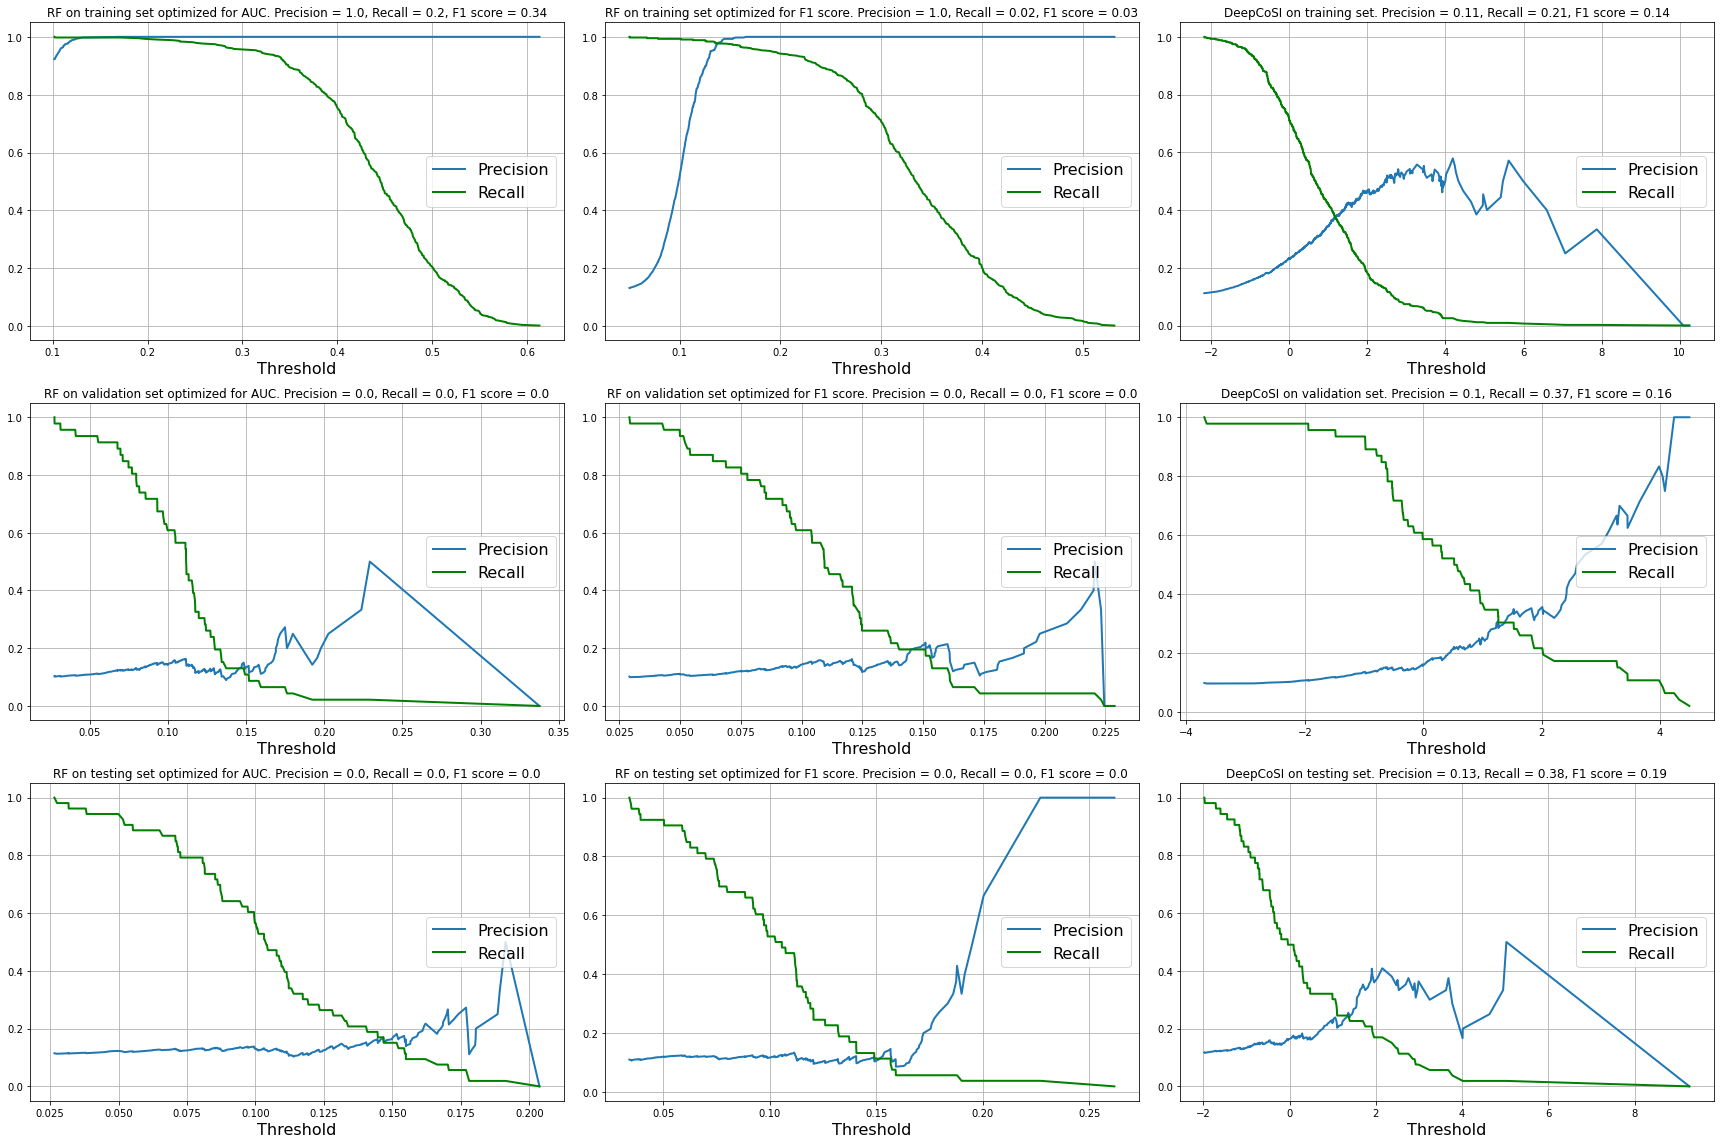

In [524]:
fig = plt.figure(figsize=(24,16))
ax1 = plt.subplot(3,3,1)
plot_precision_recall_vs_threshold(train_precision_auc, train_recall_auc, train_threshold_auc, ax=ax1)
plt.title(f'RF on training set optimized for AUC. Precision = {round(precision_score(train_ys,train_pred_ys_opt_auc),2)}, Recall = {round(recall_score(train_ys,train_pred_ys_opt_auc), 2)}, F1 score = {round(f1_score(train_ys,train_pred_ys_opt_auc), 2)}')

ax2 = plt.subplot(3,3,2)
plot_precision_recall_vs_threshold(train_precision_f1, train_recall_f1, train_threshold_f1, ax=ax2)
plt.title(f'RF on training set optimized for F1 score. Precision = {round(precision_score(train_ys,train_pred_ys_opt_f1),2)}, Recall = {round(recall_score(train_ys,train_pred_ys_opt_f1),2)}, F1 score = {round(f1_score(train_ys,train_pred_ys_opt_f1), 2)}')

ax3 = plt.subplot(3,3,3)
plot_precision_recall_vs_threshold(train_precision, train_recall, train_threshold, ax=ax3)
plt.title(f'DeepCoSI on training set. Precision = {round(precision_score(train_ys,train_pred_bin),2)}, Recall = {round(recall_score(train_ys,train_pred_bin),2)}, F1 score = {round(f1_score(train_ys,train_pred_bin), 2)}')

ax4 = plt.subplot(3,3,4)
plot_precision_recall_vs_threshold(valid_precision_auc, valid_recall_auc, valid_threshold_auc, ax=ax4)
plt.title(f'RF on validation set optimized for AUC. Precision = {round(precision_score(valid_ys,valid_pred_ys_opt_auc),2)}, Recall = {round(recall_score(valid_ys,valid_pred_ys_opt_auc), 2)}, F1 score = {round(f1_score(valid_ys,valid_pred_ys_opt_auc), 2)}')

ax5 = plt.subplot(3,3,5)
plot_precision_recall_vs_threshold(valid_precision_f1, valid_recall_f1, valid_threshold_f1, ax=ax5)
plt.title(f'RF on validation set optimized for F1 score. Precision = {round(precision_score(valid_ys,valid_pred_ys_opt_f1),2)}, Recall = {round(recall_score(valid_ys,valid_pred_ys_opt_f1),2)}, F1 score = {round(f1_score(valid_ys,valid_pred_ys_opt_f1), 2)}')

ax6 = plt.subplot(3,3,6)
plot_precision_recall_vs_threshold(valid_precision, valid_recall, valid_threshold, ax=ax6)
plt.title(f'DeepCoSI on validation set. Precision = {round(precision_score(valid_ys,valid_pred_bin),2)}, Recall = {round(recall_score(valid_ys,valid_pred_bin),2)}, F1 score = {round(f1_score(valid_ys,valid_pred_bin), 2)}')

ax7 = plt.subplot(3,3,7)
plot_precision_recall_vs_threshold(test_precision_auc, test_recall_auc, test_threshold_auc, ax=ax7)
plt.title(f'RF on testing set optimized for AUC. Precision = {round(precision_score(test_ys,test_pred_ys_opt_auc),2)}, Recall = {round(recall_score(test_ys,test_pred_ys_opt_auc), 2)}, F1 score = {round(f1_score(test_ys,test_pred_ys_opt_auc), 2)}')

ax8 = plt.subplot(3,3,8)
plot_precision_recall_vs_threshold(test_precision_f1, test_recall_f1, test_threshold_f1, ax=ax8)
plt.title(f'RF on testing set optimized for F1 score. Precision = {round(precision_score(test_ys,test_pred_ys_opt_f1),2)}, Recall = {round(recall_score(test_ys,test_pred_ys_opt_f1),2)}, F1 score = {round(f1_score(test_ys,test_pred_ys_opt_f1), 2)}')

ax9 = plt.subplot(3,3,9)
plot_precision_recall_vs_threshold(test_precision, test_recall, test_threshold, ax=ax9)
plt.title(f'DeepCoSI on testing set. Precision = {round(precision_score(test_ys,test_pred_bin),2)}, Recall = {round(recall_score(test_ys,test_pred_bin),2)}, F1 score = {round(f1_score(test_ys,test_pred_bin), 2)}')
plt.tight_layout()

In [525]:
test_precision_random, test_recall_random, test_threshold_random

(array([0.1064257, 1.       ]), array([1., 0.]), array([0.5]))

In [526]:
test_precision_inactive, test_recall_inactive, test_threshold_inactive

(array([0.1064257, 1.       ]), array([1., 0.]), array([0.10423216]))

Text(0.5, 1.0, 'DeepCoSI and the AUPRC value')

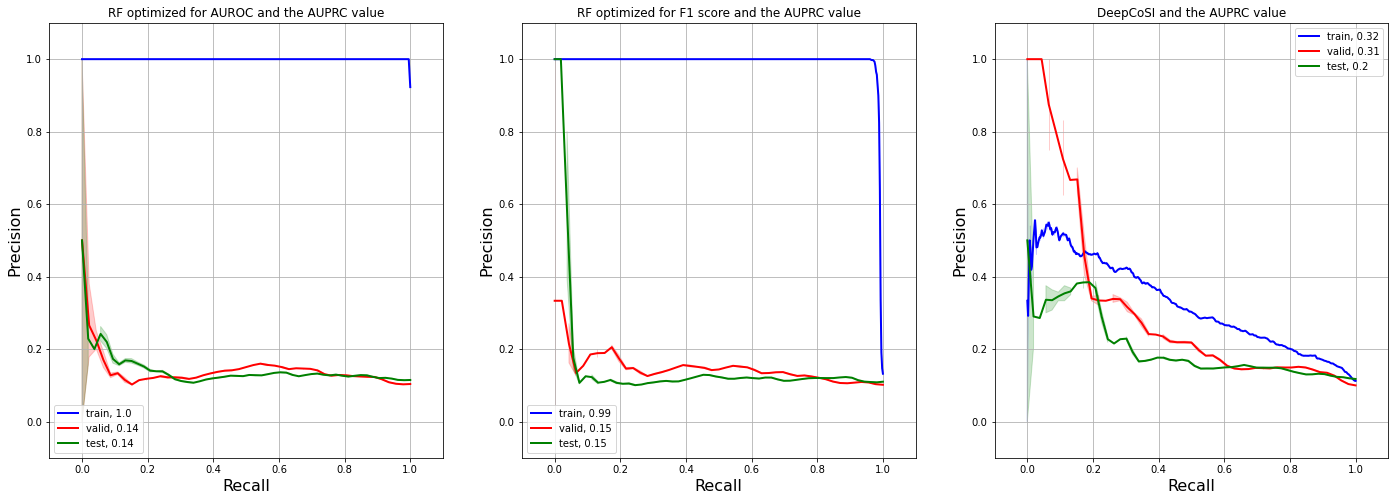

In [527]:
fig = plt.figure(figsize=(24,8))
ax1 = plt.subplot(1,3,1)
plot_precision_vs_recall(train_precision_auc, train_recall_auc,color='blue',label=f'train, {round(auc(train_recall_auc, train_precision_auc),2)}', ax=ax1)
plot_precision_vs_recall(valid_precision_auc, valid_recall_auc,color='red', label=f'valid, {round(auc(valid_recall_auc, valid_precision_auc),2)}', ax=ax1)
plot_precision_vs_recall(test_precision_auc, test_recall_auc,color='green', label=f'test, {round(auc(test_recall_auc, test_precision_auc),2)}', ax=ax1)
plt.legend()
plt.title('RF optimized for AUROC and the AUPRC value')

ax2 = plt.subplot(1,3,2)
plot_precision_vs_recall(train_precision_f1, train_recall_f1,color='blue',label=f'train, {round(auc(train_recall_f1, train_precision_f1),2)}', ax=ax2)
plot_precision_vs_recall(valid_precision_f1, valid_recall_f1,color='red', label=f'valid, {round(auc(valid_recall_f1, valid_precision_f1),2)}', ax=ax2)
plot_precision_vs_recall(test_precision_f1, test_recall_f1,color='green', label=f'test, {round(auc(test_recall_f1, test_precision_f1),2)}', ax=ax2)
plt.title('RF optimized for F1 score and the AUPRC value')

ax3 = plt.subplot(1,3,3)
plot_precision_vs_recall(train_precision, train_recall,color='blue',label=f'train, {round(train_auprc,2)}', ax=ax3)
plot_precision_vs_recall(valid_precision, valid_recall,color='red', label=f'valid, {round(valid_auprc,2)}', ax=ax3)
plot_precision_vs_recall(test_precision, test_recall,color='green', label=f'test, {round(test_auprc,2)}', ax=ax3)
plt.title('DeepCoSI and the AUPRC value')

In [528]:
train_fpr_auc, train_tpr_auc, train_thresholds_auc = roc_curve(train_ys, train_pred_proba_ys_opt_auc[:,1])
valid_fpr_auc, valid_tpr_auc, valid_thresholds_auc = roc_curve(valid_ys, valid_pred_proba_ys_opt_auc[:,1])
test_fpr_auc, test_tpr_auc, test_thresholds_auc = roc_curve(test_ys, test_pred_proba_ys_opt_auc[:,1])

train_fpr_f1, train_tpr_f1, train_thresholds_f1 = roc_curve(train_ys, train_pred_proba_ys_opt_f1[:,1])
valid_fpr_f1, valid_tpr_f1, valid_thresholds_f1 = roc_curve(valid_ys, valid_pred_proba_ys_opt_f1[:,1])
test_fpr_f1, test_tpr_f1, test_thresholds_f1 = roc_curve(test_ys, test_pred_proba_ys_opt_f1[:,1])

train_fpr, train_tpr, train_thresholds = roc_curve(train_ys, train_pred)
valid_fpr, valid_tpr, valid_thresholds = roc_curve(valid_ys, valid_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(test_ys, test_pred)

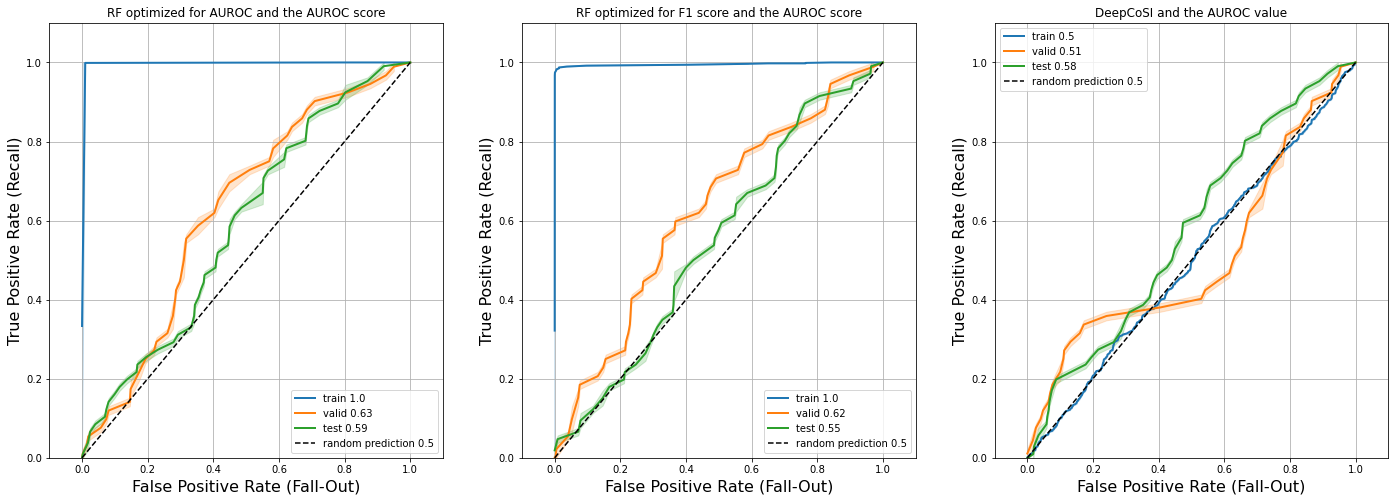

In [529]:
fig = plt.figure(figsize=(24,8))
ax1 = plt.subplot(1,3,1)
plot_roc_curve(train_fpr_auc, train_tpr_auc, label=f'train {round(roc_auc_score(train_ys, train_pred_proba_ys_opt_auc[:,1]),2)}', ax=ax1)
plot_roc_curve(valid_fpr_auc, valid_tpr_auc, label=f'valid {round(roc_auc_score(valid_ys, valid_pred_proba_ys_opt_auc[:,1]),2)}', ax=ax1)
plot_roc_curve(test_fpr_auc, test_tpr_auc, label=f'test {round(roc_auc_score(test_ys, test_pred_proba_ys_opt_auc[:,1]),2)} ', ax=ax1)
plt.plot([0, 1], [0, 1], 'k--', label='random prediction 0.5')
plt.title('RF optimized for AUROC and the AUROC score')
plt.legend()

ax2 = plt.subplot(1,3,2)
plot_roc_curve(train_fpr_f1, train_tpr_f1, label=f'train {round(roc_auc_score(train_ys, train_pred_proba_ys_opt_f1[:,1]),2)}', ax=ax2)
plot_roc_curve(valid_fpr_f1, valid_tpr_f1, label=f'valid {round(roc_auc_score(valid_ys, valid_pred_proba_ys_opt_f1[:,1]),2)}', ax=ax2)
plot_roc_curve(test_fpr_f1, test_tpr_f1, label=f'test {round(roc_auc_score(test_ys, test_pred_proba_ys_opt_f1[:,1]),2)} ', ax=ax2)
plt.plot([0, 1], [0, 1], 'k--', label='random prediction 0.5')
plt.title('RF optimized for F1 score and the AUROC score')
plt.legend()

ax3 = plt.subplot(1,3,3)
plot_roc_curve(train_fpr, train_tpr, label=f'train {round(roc_auc_score(train_ys, train_pred),2)}', ax=ax3)
plot_roc_curve(valid_fpr, valid_tpr, label=f'valid {round(roc_auc_score(valid_ys, valid_pred),2)}', ax=ax3)
plot_roc_curve(test_fpr, test_tpr, label=f'test {round(roc_auc_score(test_ys, test_pred),2)} ', ax=ax3)
plt.plot([0, 1], [0, 1], 'k--', label='random prediction 0.5')
plt.title('DeepCoSI and the AUROC value')
plt.legend()

In [530]:
train_fpr_random, train_tpr_random, train_thresholds_random = roc_curve(train_ys, train_pred_proba_ys_random[:,1])
valid_fpr_random, valid_tpr_random, valid_thresholds_random = roc_curve(valid_ys, valid_pred_proba_ys_random[:,1])
test_fpr_random, test_tpr_random, test_thresholds_random = roc_curve(test_ys, test_pred_proba_ys_random[:,1])

train_fpr_inactive, train_tpr_inactive, train_thresholds_inactive = roc_curve(train_ys, train_pred_proba_ys_inactive[:,1])
valid_fpr_inactive, valid_tpr_inactive, valid_thresholds_inactive = roc_curve(valid_ys, valid_pred_proba_ys_inactive[:,1])
test_fpr_inactive, test_tpr_inactive, test_thresholds_inactive = roc_curve(test_ys, test_pred_proba_ys_inactive[:,1])

In [531]:
train_fpr_random, train_tpr_random, train_thresholds_random

(array([0., 1.]), array([0., 1.]), array([1.5, 0.5]))

In [532]:
valid_fpr_random, valid_tpr_random, valid_thresholds_random

(array([0., 1.]), array([0., 1.]), array([1.5, 0.5]))

In [533]:
train_fpr_inactive, train_tpr_inactive, train_thresholds_inactive

(array([0., 1.]), array([0., 1.]), array([1.10423216, 0.10423216]))

In [534]:
valid_fpr_inactive, valid_tpr_inactive, valid_thresholds_inactive

(array([0., 1.]), array([0., 1.]), array([1.10423216, 0.10423216]))

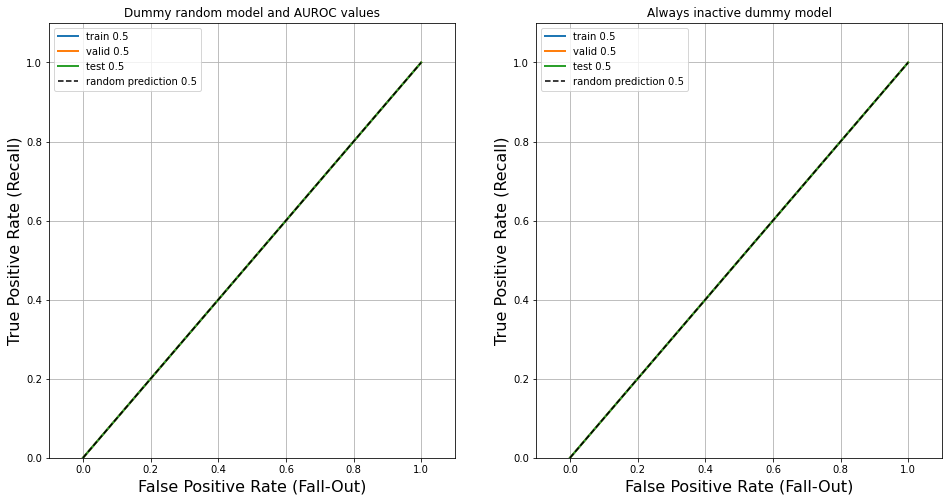

In [535]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
plot_roc_curve(train_fpr_random, train_tpr_random, label=f'train {round(roc_auc_score(train_ys, train_pred_proba_ys_random[:,1]),2)}', ax=ax1)
plot_roc_curve(valid_fpr_random, valid_tpr_random, label=f'valid {round(roc_auc_score(valid_ys, valid_pred_proba_ys_random[:,1]),2)}', ax=ax1)
plot_roc_curve(test_fpr_random, test_tpr_random, label=f'test {round(roc_auc_score(test_ys, test_pred_proba_ys_random[:,1]),2)} ', ax=ax1)
plt.plot([0, 1], [0, 1], 'k--', label='random prediction 0.5')
plt.title('Dummy random model and AUROC values')
plt.legend()

ax2 = plt.subplot(1,2,2)
plot_roc_curve(train_fpr_inactive, train_tpr_inactive, label=f'train {round(roc_auc_score(train_ys, train_pred_proba_ys_inactive[:,1]),2)}', ax=ax2)
plot_roc_curve(valid_fpr_inactive, valid_tpr_inactive, label=f'valid {round(roc_auc_score(valid_ys, valid_pred_proba_ys_inactive[:,1]),2)}', ax=ax2)
plot_roc_curve(test_fpr_inactive, test_tpr_inactive, label=f'test {round(roc_auc_score(test_ys, test_pred_proba_ys_inactive[:,1]),2)} ', ax=ax2)
plt.plot([0, 1], [0, 1], 'k--', label='random prediction 0.5')
plt.title('Always inactive dummy model')
plt.legend()

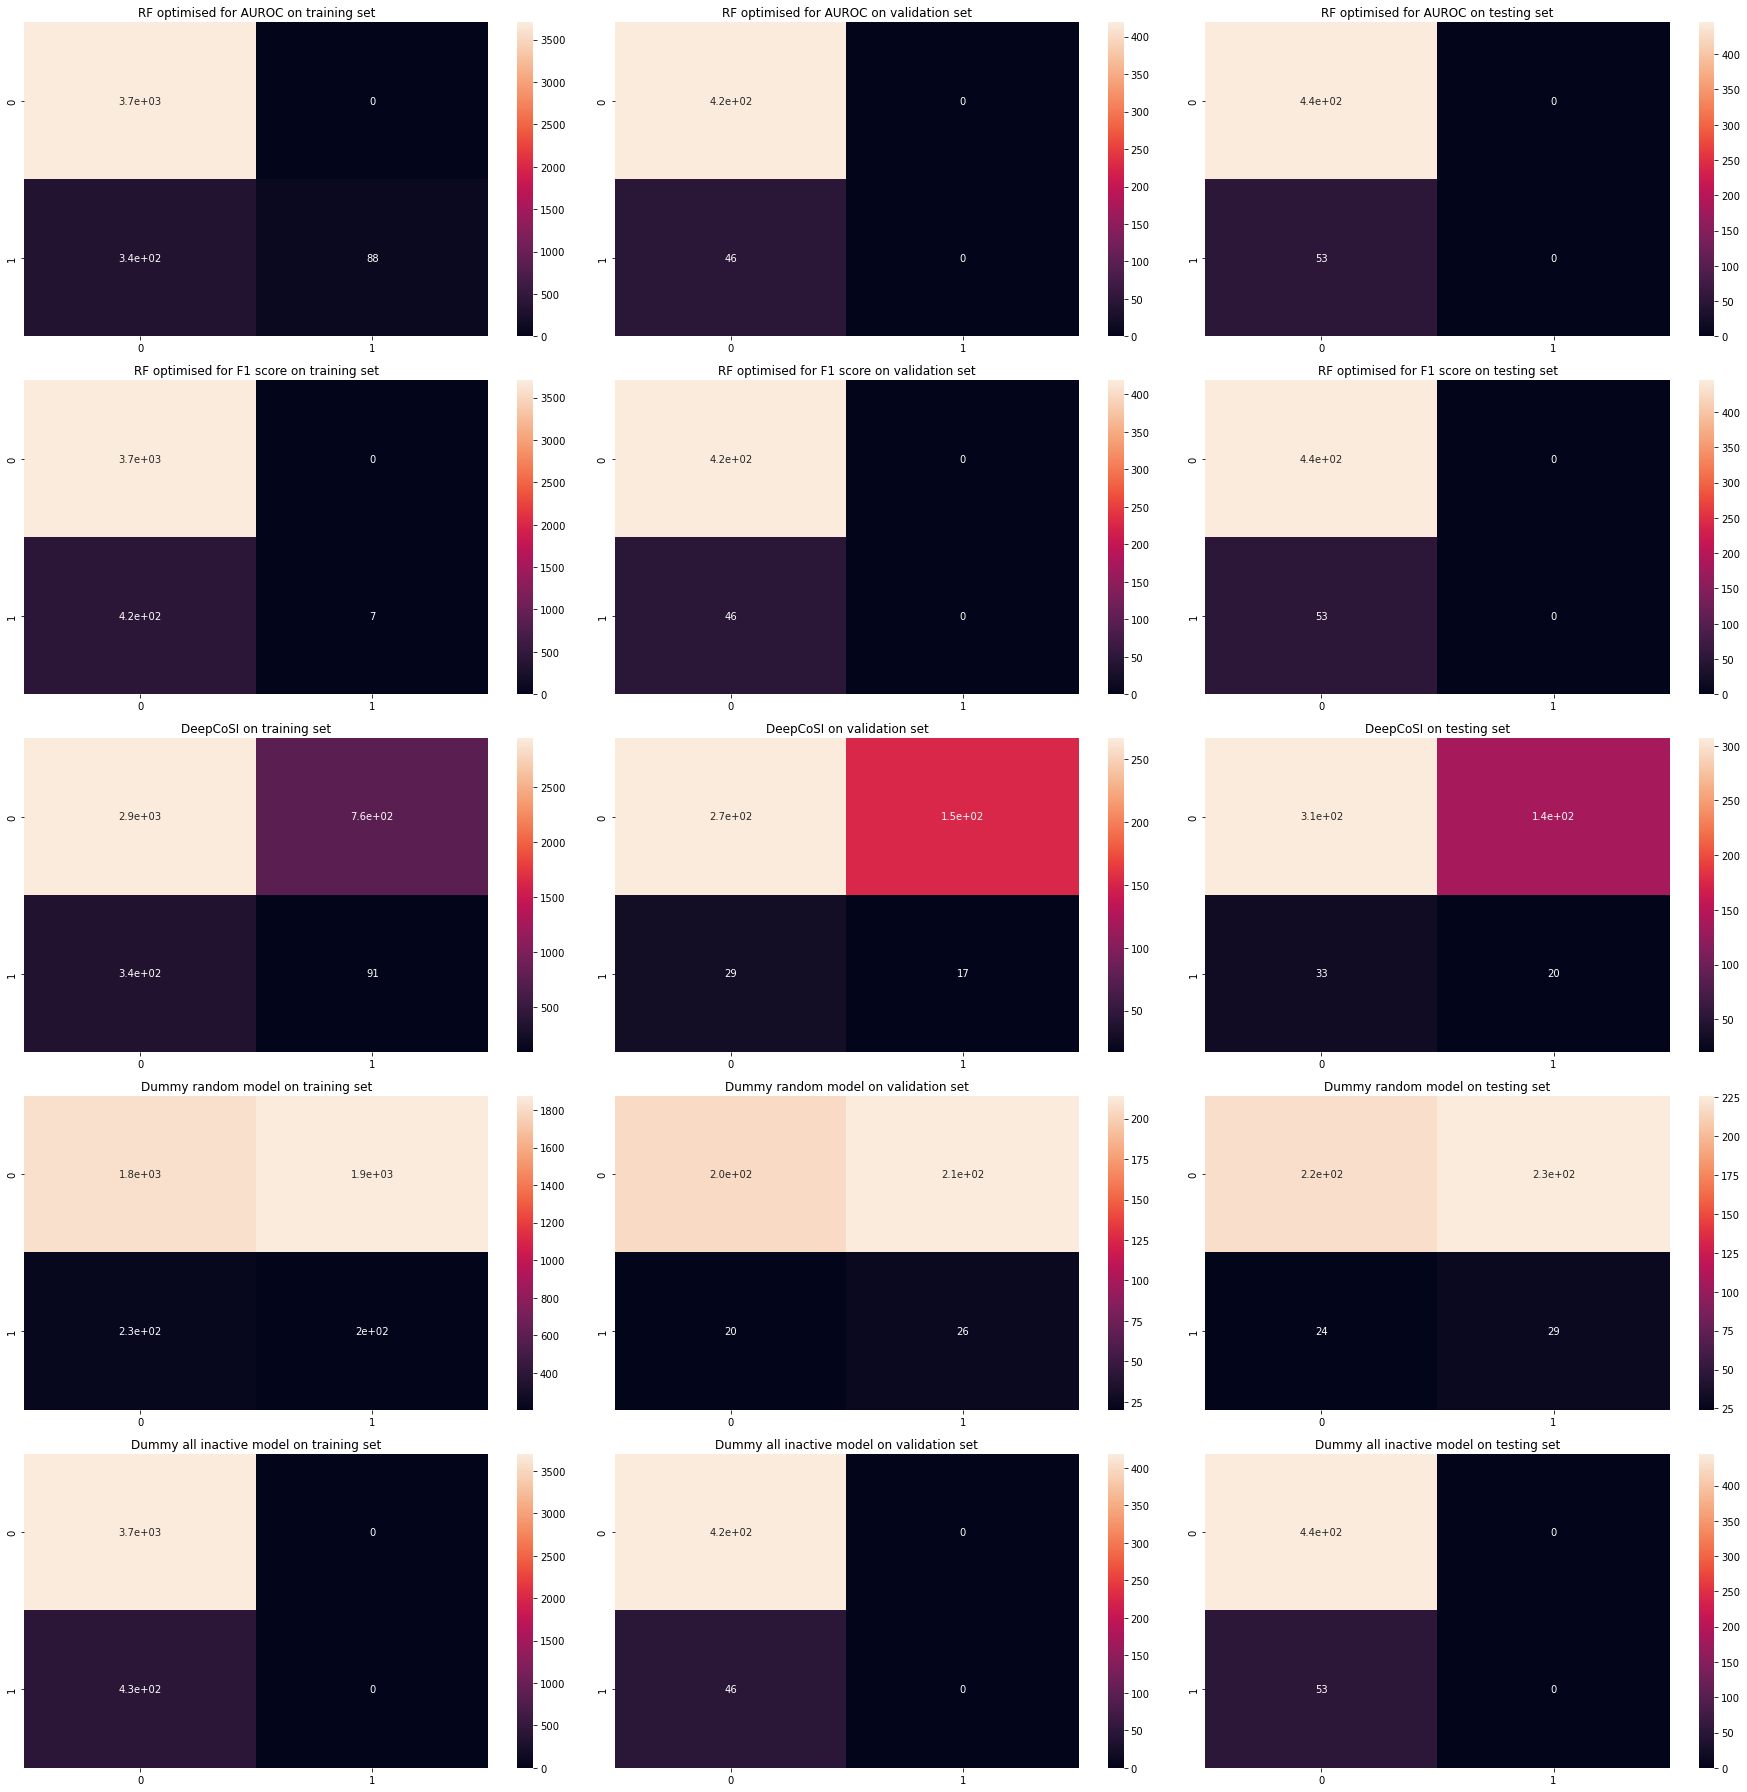

In [549]:
fig = plt.figure(figsize=(25,25))
ax1 = plt.subplot(5,3,1)
sn.heatmap(confusion_matrix(train_ys, train_pred_ys_opt_auc), annot=True, ax=ax1)
plt.title('RF optimised for AUROC on training set')
ax2 = plt.subplot(5,3,2)
sn.heatmap(confusion_matrix(valid_ys, valid_pred_ys_opt_auc), annot=True, ax=ax2)
plt.title('RF optimised for AUROC on validation set')
ax3 = plt.subplot(5,3,3)
sn.heatmap(confusion_matrix(test_ys, test_pred_ys_opt_auc), annot=True, ax=ax3)
plt.title('RF optimised for AUROC on testing set')

ax4 = plt.subplot(5,3,4)
sn.heatmap(confusion_matrix(train_ys, train_pred_ys_opt_f1), annot=True, ax=ax4)
plt.title('RF optimised for F1 score on training set')
ax5 = plt.subplot(5,3,5)
sn.heatmap(confusion_matrix(valid_ys, valid_pred_ys_opt_f1), annot=True, ax=ax5)
plt.title('RF optimised for F1 score on validation set')
ax6 = plt.subplot(5,3,6)
sn.heatmap(confusion_matrix(test_ys, test_pred_ys_opt_f1), annot=True, ax=ax6)
plt.title('RF optimised for F1 score on testing set')

ax7 = plt.subplot(5,3,7)
sn.heatmap(confusion_matrix(train_ys, train_pred_bin), annot=True, ax=ax7)
plt.title('DeepCoSI on training set')
ax8 = plt.subplot(5,3,8)
sn.heatmap(confusion_matrix(valid_ys, valid_pred_bin), annot=True, ax=ax8)
plt.title('DeepCoSI on validation set')
ax9 = plt.subplot(5,3,9)
sn.heatmap(confusion_matrix(test_ys, test_pred_bin), annot=True, ax=ax9)
plt.title('DeepCoSI on testing set')

ax10 = plt.subplot(5,3,10)
sn.heatmap(confusion_matrix(train_ys, train_pred_ys_random), annot=True, ax=ax10)
plt.title('Dummy random model on training set')
ax11 = plt.subplot(5,3,11)
sn.heatmap(confusion_matrix(valid_ys, valid_pred_ys_random), annot=True, ax=ax11)
plt.title('Dummy random model on validation set')
ax12 = plt.subplot(5,3,12)
sn.heatmap(confusion_matrix(test_ys, test_pred_ys_random), annot=True, ax=ax12)
plt.title('Dummy random model on testing set')

ax13 = plt.subplot(5,3,13)
sn.heatmap(confusion_matrix(train_ys, train_pred_ys_inactive), annot=True, ax=ax13)
plt.title('Dummy all inactive model on training set')
ax14 = plt.subplot(5,3,14)
sn.heatmap(confusion_matrix(valid_ys, valid_pred_ys_inactive), annot=True, ax=ax14)
plt.title('Dummy all inactive model on validation set')
ax15 = plt.subplot(5,3,15)
sn.heatmap(confusion_matrix(test_ys, test_pred_ys_inactive), annot=True, ax=ax15)
plt.title('Dummy all inactive model on testing set')
plt.tight_layout()

# Accuracies

DeepCoSI: 
    train: 0.73
    valid: 0.61
    test: 0.66

RF optimized for AUROC:
    train: 0.92
    valid: 0.90
    test: 0.89

RF optimized for F1:
    train: 0.90
    valid: 0.90
    test: 0.89

Dummy random:
    train: 0.49
    valid: 0.49
    test: 0.49

Dummy all negative:
    train: 0.90
    valid: 0.90
    test: 0.90

In [537]:
accuracy_score(train_ys, train_pred_bin)

0.7339782345828295

In [538]:
accuracy_score(valid_ys, valid_pred_bin)

0.610752688172043

In [539]:
accuracy_score(test_ys, test_pred_bin)

0.6566265060240963

In [540]:
accuracy_score(train_ys, train_pred_ys_opt_auc)

0.917049576783555

In [541]:
accuracy_score(valid_ys, valid_pred_ys_opt_auc)

0.9010752688172043

In [542]:
accuracy_score(test_ys, test_pred_ys_opt_auc)

0.893574297188755

In [543]:
accuracy_score(train_ys, train_pred_ys_opt_f1)

0.8974607013301088

In [544]:
accuracy_score(valid_ys, valid_pred_ys_opt_f1)

0.9010752688172043

In [545]:
accuracy_score(test_ys, test_pred_ys_opt_f1)

0.893574297188755

In [546]:
accuracy_score(train_ys, train_pred_ys_random),accuracy_score(train_ys, train_pred_ys_random),accuracy_score(train_ys, train_pred_ys_random)

(0.4911729141475212, 0.4911729141475212, 0.4911729141475212)

In [547]:
accuracy_score(train_ys, train_pred_ys_inactive),accuracy_score(train_ys, train_pred_ys_inactive),accuracy_score(train_ys, train_pred_ys_inactive)

(0.8957678355501814, 0.8957678355501814, 0.8957678355501814)